# Linear Regression with Gaussian Pulses

### Note: Risks with looking into the future due to mean, standard deviation, and normalization. 
Feature engineering involves transforming raw data into meaningful features that improve model performance. In this section, we will explore the Gaussian Pulses approach and train a linear regression model using these features.

1. [Data Retrieval](#retrieval)
2. [Gaussian Pulses](#gauss)
3. [Linear Regression](#linear)

## Imports

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
import matplotlib.pyplot as plt
from util import get_stock, bin_data, split_data
import math

<a id="retrieval"></a>
## 1. Data Retrieval

In [3]:
# Define the stock and date range
start = '1980-01-01'
end = '2024-08-10'
stock = '^GSPC'

df, _, index = get_stock(start, end, stock, 0)
print(df)

[*********************100%***********************]  1 of 1 completed

[[ 105.76000214]
 [ 105.22000122]
 [ 106.51999664]
 ...
 [5199.5       ]
 [5319.31005859]
 [5344.16015625]]


<a id="gauss"></a>
## 2. Gaussian Pulses Approach

We will turn the financial data into a smooth curve using Gaussian distributions to avoid pickup up on noise. <br>
A Gaussian distribution is defined as:

&emsp; $f(x) = Ae^{-\frac{(x-\mu)^2}{2\sigma^2}}$ 

where:
- $A$ is the amplitude
- $\mu$ is the mean (center of the pulse)
- $\sigma$ is the standard deviation (width of the pulse)

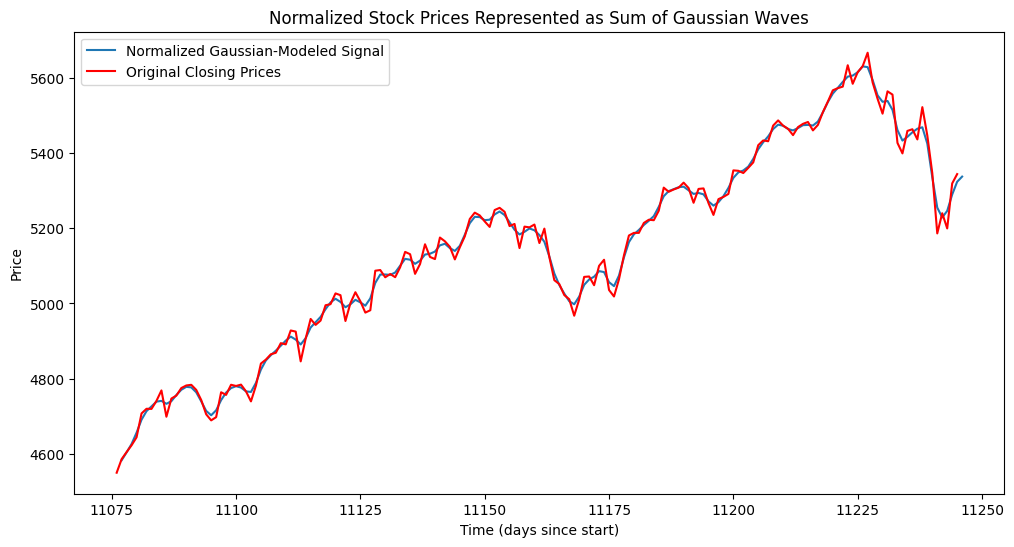

In [4]:
# Time axis for Gaussian pulses
t_continuous = np.linspace(1, len(df), num=len(df))
signal = np.zeros(t_continuous.shape)
gaussian_basis_sum = np.zeros_like(t_continuous)  # Sum of Gaussians

# Standard deviation for Gaussian pulses
sigma = 1
n = len(df)
t = np.arange(n)  # Creating t as a range based on the array length
gaussian_matrix = np.zeros((n, len(t_continuous)))

# Sum of Gaussian pulses
for i in range(n):
    A = df[i]  # Stock price as amplitude
    t0 = float(t[i])  # Ensure t0 is a scalar by casting to float
    
    # Gaussian pulse with amplitude A
    gaussian_pulse = A * np.exp(-((t_continuous - t0) ** 2) / (2 * sigma ** 2))
    signal += gaussian_pulse
    gaussian_matrix[i, :] = gaussian_pulse

    # Gaussian basis with amplitude 1
    gaussian_basis = np.exp(-((t_continuous - t0) ** 2) / (2 * sigma ** 2))
    gaussian_basis_sum += gaussian_basis

# Avoid dividing by zero by replacing zeros with small values in gaussian_basis_sum
gaussian_basis_sum[gaussian_basis_sum == 0] = 1e-8
normalized_signal = signal / gaussian_basis_sum

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t_continuous[-170:], normalized_signal[-170:], label='Normalized Gaussian-Modeled Signal')
plt.plot(t[-170:], df[-170:], color='red', label='Original Closing Prices')
plt.title('Normalized Stock Prices Represented as Sum of Gaussian Waves')
plt.xlabel('Time (days since start)')
plt.ylabel('Price')
plt.legend()
plt.show()

**Caution: Making sigma higher then 2 causes highly volatile predictions near the end of the stock

<a id="linear"></a>
## 3. Linear Regression
We use the Scikit-learn library for the linear regression model.

### 3.1 Training
We split the data into training and testing sets. Then, we train the linear regression model on the training data. Once the linear regression model is trained on the data, we can generate predictions using the fitted model.

In [6]:
bin_size = 365
bins = bin_data(normalized_signal, bin_size)
X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size = split_data(bins, df, index, bin_size)

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [8]:
# now we make some predictions
y_pred = np.floor(model.predict(X_test))
y_test = np.floor(y_test)
print(y_pred.shape, y_test.shape)

for i in range(math.floor(len(y_pred) * 0.01)):
    print("prediction:", y_pred[i], "| actual:", y_test[i], "| difference:", abs(y_pred[i] - y_test[i]))
# print(y_pred)
print(X_test.shape)

(2176,) (2176,)
prediction: 2051.0 | actual: 2043.0 | difference: 8.0
prediction: 2057.0 | actual: 2073.0 | difference: 16.0
prediction: 2045.0 | actual: 2041.0 | difference: 4.0
prediction: 2008.0 | actual: 2005.0 | difference: 3.0
prediction: 2024.0 | actual: 2021.0 | difference: 3.0
prediction: 2042.0 | actual: 2038.0 | difference: 4.0
prediction: 2060.0 | actual: 2064.0 | difference: 4.0
prediction: 2064.0 | actual: 2060.0 | difference: 4.0
prediction: 2056.0 | actual: 2056.0 | difference: 0.0
prediction: 2071.0 | actual: 2078.0 | difference: 7.0
prediction: 2063.0 | actual: 2063.0 | difference: 0.0
prediction: 2038.0 | actual: 2043.0 | difference: 5.0
prediction: 2015.0 | actual: 2012.0 | difference: 3.0
prediction: 2007.0 | actual: 2016.0 | difference: 9.0
prediction: 1987.0 | actual: 1990.0 | difference: 3.0
prediction: 1941.0 | actual: 1943.0 | difference: 2.0
prediction: 1924.0 | actual: 1922.0 | difference: 2.0
prediction: 1924.0 | actual: 1923.0 | difference: 1.0
prediction:

(8704,) (2176,)


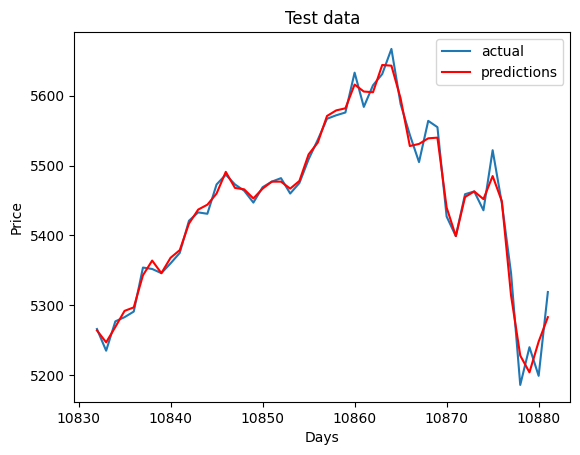

Correctly Classified: 1917/2176
Accuracy: 88.09742647058823%, error_margin of $20
Correctly Classified: 2155/2176
Accuracy: 99.03492647058823%, error_margin of $50


In [9]:
print(train_index.shape, test_index.shape)
plt.plot(test_index[-50:], y_test[-50:], label="actual")
plt.plot(test_index[-50:], y_pred[-50:], color="red", label="predictions")
plt.title("Test data")
plt.ylabel("Price")
plt.xlabel("Days")
plt.legend()
plt.show()

error_margin = 20
results = abs(y_pred - y_test) <= error_margin
print(f"Correctly Classified: {np.sum(results)}/{len(results)}")
print(f"Accuracy: {100 * np.sum(results) / len(results)}%, error_margin of ${error_margin}")

error_margin = 50
results = abs(y_pred - y_test) <= error_margin
print(f"Correctly Classified: {np.sum(results)}/{len(results)}")
print(f"Accuracy: {100 * np.sum(results) / len(results)}%, error_margin of ${error_margin}")

In [10]:
print(f"Tomorrows Price: {y_pred[-1]}")
print(y_pred[-15:])
print(y_test[-15:])

Tomorrows Price: 5283.0
[5531. 5539. 5540. 5440. 5399. 5455. 5463. 5452. 5485. 5449. 5314. 5228.
 5204. 5248. 5283.]
[5505. 5564. 5555. 5427. 5399. 5459. 5463. 5436. 5522. 5446. 5346. 5186.
 5240. 5199. 5319.]


### 3.2 Testing
We create a function that integrates all the previous components and generates graphs comparing the actual stock prices with the predicted ones. The stocks we use are S&P 500, Vanguard S&P 500, Vanguard Institutional Index Fund, iShares Core, Dow Jones, and Apple.

In [11]:
def test_stock(stock, bin_size=365):

    # Get the stock data
    df, index = get_stock(stock[1], stock[2], stock[0])

    # Time axis for Gaussian pulses
    t_continuous = np.linspace(1, len(df), num=len(df))
    signal = np.zeros(t_continuous.shape)
    gaussian_basis_sum = np.zeros_like(t_continuous)  # Sum of Gaussians
    
    # Standard deviation for Gaussian pulses
    sigma = 2
    n = len(df)
    t = np.arange(n)  # Creating t as a range based on the array length
    gaussian_matrix = np.zeros((n, len(t_continuous)))
    
    # Sum of Gaussian pulses
    for i in range(n):
        A = df[i]  # Stock price as amplitude
        t0 = float(t[i])  # Ensure t0 is a scalar by casting to float
        
        # Gaussian pulse with amplitude A
        gaussian_pulse = A * np.exp(-((t_continuous - t0) ** 2) / (2 * sigma ** 2))
        signal += gaussian_pulse
        gaussian_matrix[i, :] = gaussian_pulse
    
        # Gaussian basis with amplitude 1
        gaussian_basis = np.exp(-((t_continuous - t0) ** 2) / (2 * sigma ** 2))
        gaussian_basis_sum += gaussian_basis
    
    # Avoid dividing by zero by replacing zeros with small values in gaussian_basis_sum
    gaussian_basis_sum[gaussian_basis_sum == 0] = 1e-8
    normalized_signal = signal / gaussian_basis_sum

    # Create bins
    bins = bin_data(normalized_signal)

    # Split the data
    X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size = split_data(bins, df, index, bin_size)

    # Run the linear model
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = np.floor(model.predict(X_test))
    y_test = np.floor(y_test)
    
    
    plt.plot(test_index[-100:], y_test[-100:], label="actual")
    plt.plot(test_index[-100:], y_pred[-100:], color="red", label="predictions")
    plt.title("Test data")
    plt.ylabel("Price")
    plt.xlabel("Days")
    plt.legend()
    plt.show()

[*********************100%***********************]  1 of 1 completed


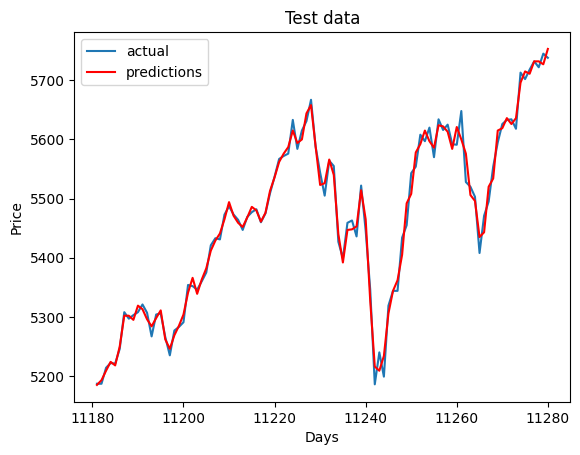

[*********************100%***********************]  1 of 1 completed


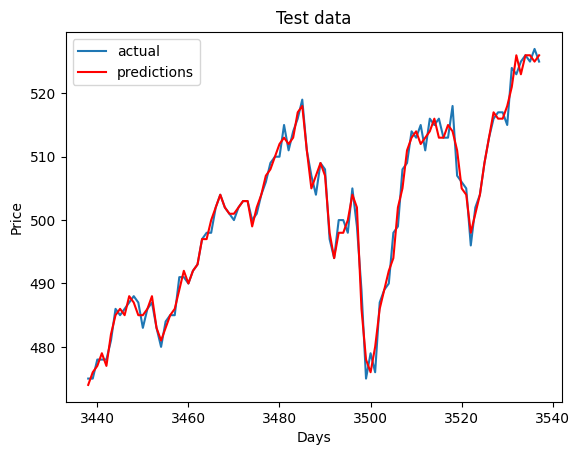

[*********************100%***********************]  1 of 1 completed


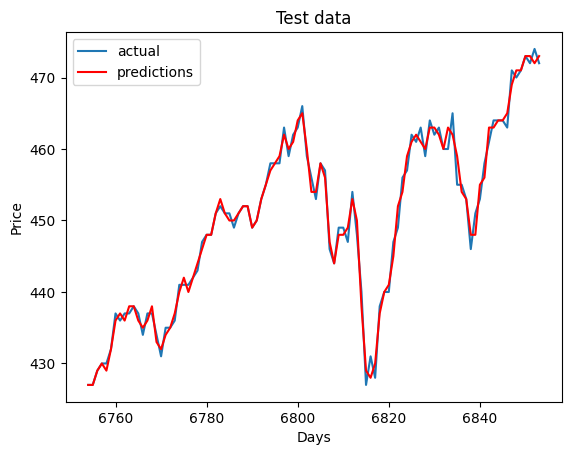

[*********************100%***********************]  1 of 1 completed


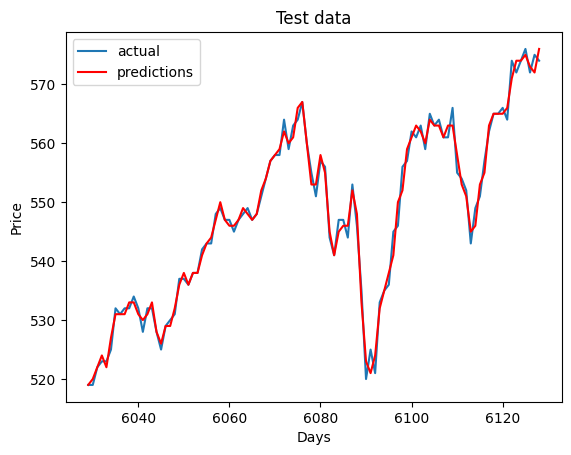

[*********************100%***********************]  1 of 1 completed


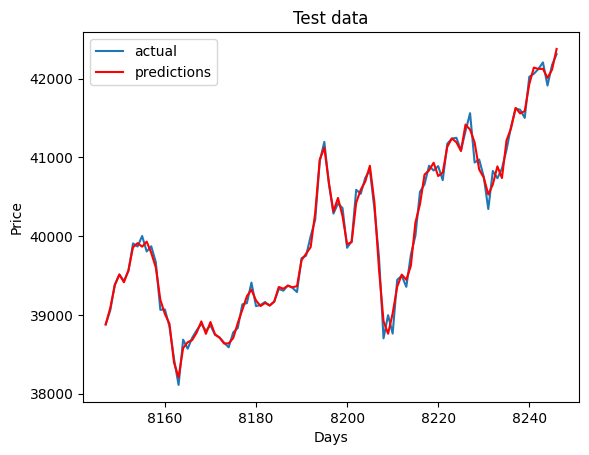

[*********************100%***********************]  1 of 1 completed


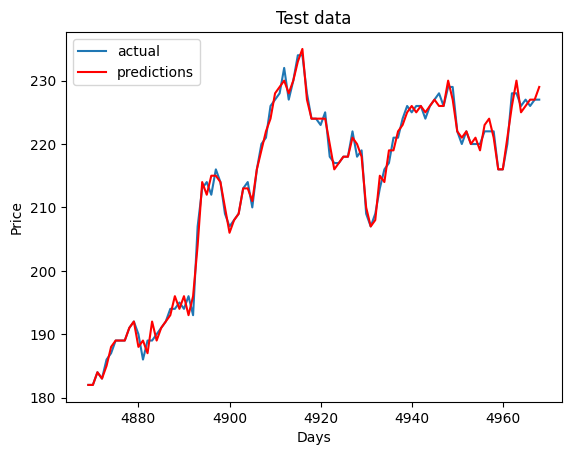

In [11]:
stock = [['^GSPC', '1980-01-01', '2024-10-01'],
        ['VOO', '1980-01-01', '2024-10-01'],
        ['VIIIX', '1980-01-01', '2024-10-01'],
        ['IVV', '1980-01-01', '2024-10-01'],
        ['^DJI', '1980-01-01', '2024-10-01'],
        ['AAPL', '2005-01-01', '2024-10-01']]
for i in stock:
    test_stock(i)